In [26]:
# 데이터 분석 모듈
import numpy as np
import pandas as pd
import random

# 통계
from scipy.stats import norm
from scipy import stats

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 데이터 전처리
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# ML
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Another
import warnings
warnings.filterwarnings('ignore')

In [27]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [28]:
import xgboost as xg

In [29]:
# 데이터 불러오기
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [30]:
# EDA: 데이터를 분석하고 결과를 내는 과정
print(train_data.head())
print('--'*20)
print(train_data.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [31]:
# 결측지 계수를 변수 3개로 데이터프레임으로 분류하여 처리. full: 결측치 없음, medium: 결측치 50% 미만, remove_me: 결측치 50% 이상
full = pd.DataFrame()
medium = pd.DataFrame()
remove_me = pd.DataFrame()

features = train_data.columns.values
number_of_houses = 1460 # or train_data.shape[0]

for feature in features:
  if train_data[feature].count() == number_of_houses:
    full[feature] = train_data[feature]
  elif train_data[feature].count() > number_of_houses*0.5: # Actually, that mean it has more than 50% non-null values
    medium[feature] = train_data[feature]
  else:
    remove_me[feature] = train_data[feature]

In [32]:
# Numerical (Output)
print('Number of numerical features: ', end='')
print(len(train_data.select_dtypes(include=['number']).columns.values))
train_data.describe(exclude=['O'])

Number of numerical features: 38


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [33]:
# Categorical
print('Number of categorical features: ', end='')
print(len(train_data.select_dtypes(include=['O']).columns.values))
train_data.describe(include=['O'])

Number of categorical features: 43


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [34]:
# 필요없는 변수 제거: Id 변수 (의미 없는 변수), Remove_me 데이터프레임에 속한 변수들 (결측치 비율 50% 이상), 결측치 비율이 높진 않지만, 대부분 0의 값을 가져 큰 의미가 없는 변수

#1
train_data = train_data.drop(['Id'], axis=1)

#2
train_data = train_data.drop(remove_me.columns.values, axis=1)

#3
#First let's create the important data we will use
numerical_data = train_data.select_dtypes(include=['number'])
categorical_data = train_data.select_dtypes(include=['object'])

#we want to know the ratio of (values equals zero) / 1460
#to each feature and if the feature has more than 50% ratio we will remove it
feature_zero_ratio = {feature:numerical_data.loc[numerical_data[feature]==0, feature].count() / 1460 for feature in numerical_data.columns.values}
feature_zero_ratio

{'MSSubClass': 0.0,
 'LotFrontage': 0.0,
 'LotArea': 0.0,
 'OverallQual': 0.0,
 'OverallCond': 0.0,
 'YearBuilt': 0.0,
 'YearRemodAdd': 0.0,
 'MasVnrArea': 0.5897260273972603,
 'BsmtFinSF1': 0.3198630136986301,
 'BsmtFinSF2': 0.8856164383561644,
 'BsmtUnfSF': 0.08082191780821918,
 'TotalBsmtSF': 0.025342465753424658,
 '1stFlrSF': 0.0,
 '2ndFlrSF': 0.5678082191780822,
 'LowQualFinSF': 0.9821917808219178,
 'GrLivArea': 0.0,
 'BsmtFullBath': 0.5863013698630137,
 'BsmtHalfBath': 0.9438356164383561,
 'FullBath': 0.0061643835616438354,
 'HalfBath': 0.6253424657534247,
 'BedroomAbvGr': 0.00410958904109589,
 'KitchenAbvGr': 0.0006849315068493151,
 'TotRmsAbvGrd': 0.0,
 'Fireplaces': 0.4726027397260274,
 'GarageYrBlt': 0.0,
 'GarageCars': 0.05547945205479452,
 'GarageArea': 0.05547945205479452,
 'WoodDeckSF': 0.5212328767123288,
 'OpenPorchSF': 0.44931506849315067,
 'EnclosedPorch': 0.8575342465753425,
 '3SsnPorch': 0.9835616438356164,
 'ScreenPorch': 0.9205479452054794,
 'PoolArea': 0.99520547

In [35]:
# 0의 비율이 0.3을 넘는 변수들을 제거
for feature in numerical_data:
  if feature_zero_ratio[feature] > 0.3:
    numerical_data = numerical_data.drop([feature],axis=1)
    train_data = train_data.drop([feature], axis=1)
    if feature in medium:
      medium = medium.drop([feature],axis=1)

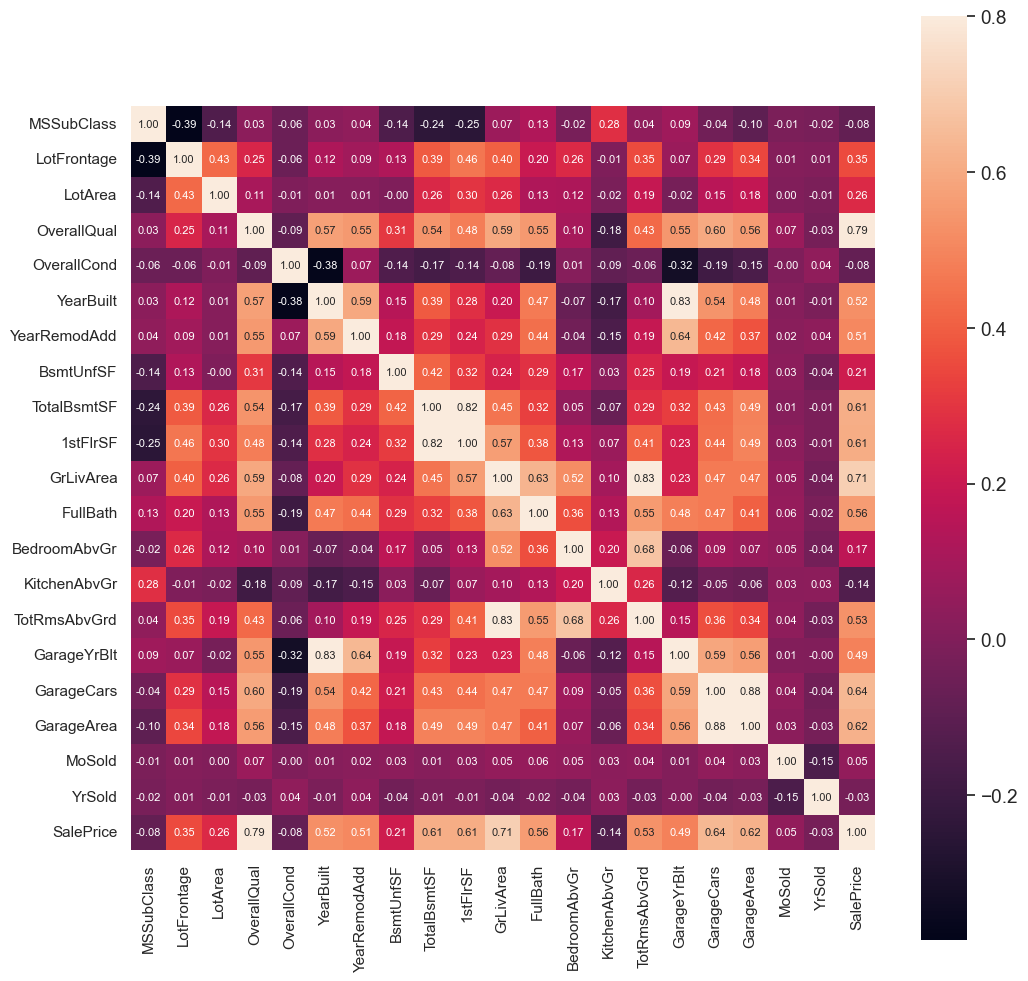

In [36]:
# seaborn 패키지의 heatmap 기능을 이용해 numerical 변수들과 target간의 상관관계 분석
corrmat = numerical_data.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, vmax=.8, annot=True, square=True, annot_kws={'size':8}, fmt='.2f')
plt.show()

['SalePrice' 'OverallQual' 'GrLivArea' 'GarageCars' 'GarageArea'
 'TotalBsmtSF' '1stFlrSF' 'FullBath' 'TotRmsAbvGrd' 'YearBuilt']


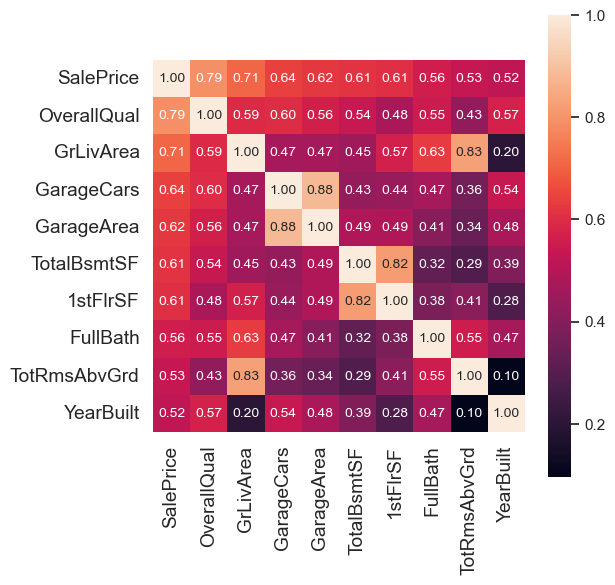

In [37]:
# Target인 SalePrice와 상관관계가 높은 상위 10개 변수들로만 다시 heatmap을 그림

n = 10
most_largest_features = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index
zoomed_corrmat = np.corrcoef(numerical_data[most_largest_features].values.T)
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1)
sns.heatmap(zoomed_corrmat, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=most_largest_features.values, xticklabels=most_largest_features.values)
print(most_largest_features.values)

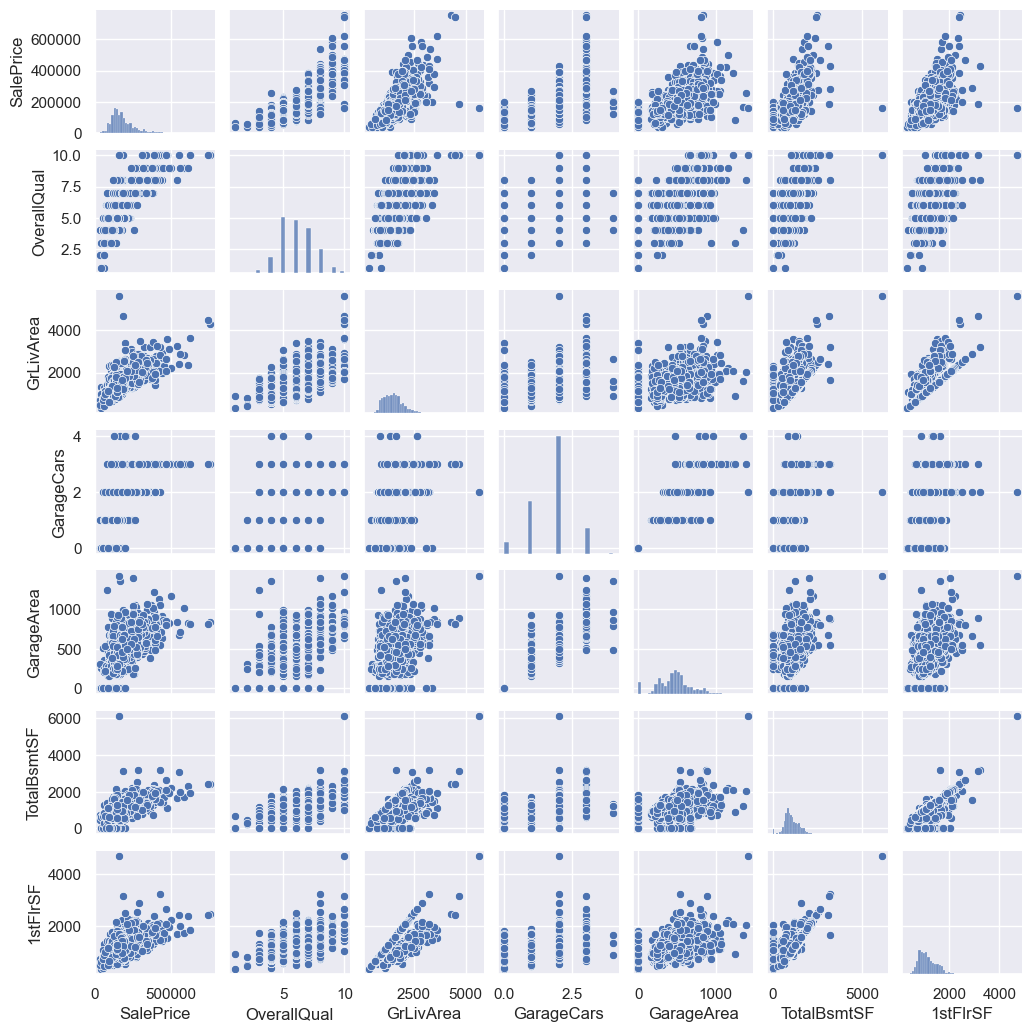

In [38]:
# Target변수와 상관관계가 높은 상위 7개의 변수들의 관계를 scatter plot으로 본다.
sns.set()
most_largest_features = corrmat.nlargest(7, 'SalePrice')['SalePrice'].index
sns.pairplot(numerical_data[most_largest_features.values],size=1.5)
plt.show()

In [39]:
# 선형관계가 존재하는 변수들 중 Target변수와 상관관계가 더 높은 변수를 남기고 낮은 변수는 제거
numerical_data = numerical_data.drop(['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt'],axis=1)
train_data = train_data.drop(['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt'],axis=1)

In [40]:
# Target변수와의 상관관계가 [-0.1, 0.2] 사이인 'nutral' 변수 제거
corr_with_price = numerical_data.corr()
corr_with_price = corr_with_price.sort_values(by='SalePrice', ascending=False)
corr_with_price['SalePrice']

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
LotFrontage     0.351799
LotArea         0.263843
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
MoSold          0.046432
YrSold         -0.028923
OverallCond    -0.077856
MSSubClass     -0.084284
KitchenAbvGr   -0.135907
Name: SalePrice, dtype: float64

In [41]:
numerical_data = numerical_data.drop(['MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'BedroomAbvGr'],axis=1)
train_data = train_data.drop(['MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'BedroomAbvGr'],axis=1)

In [44]:
numerical_have_missing = pd.DataFrame()
categorical_have_missing = pd.DataFrame()

# Numerical
for feature in numerical_data.columns.values:
    if feature in medium:
        numerical_have_missing[feature] = numerical_data[feature]
      
    
# Categorical
for feature in categorical_data.columns.values:
    if feature in medium:
        categorical_have_missing[feature] = categorical_data[feature]

In [45]:
# 결측치 처리. median으로 대체, mean으로 대체, [평균 +- 표준편차] (mean-std) to (mean+std) 사이의 random value로 대체
# Categorical 변수 - 최빈값으로 대체

print(numerical_have_missing.columns.values)
print('-'*30)
print(numerical_have_missing.info())

['LotFrontage']
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
dtypes: float64(1)
memory usage: 11.5 KB
None


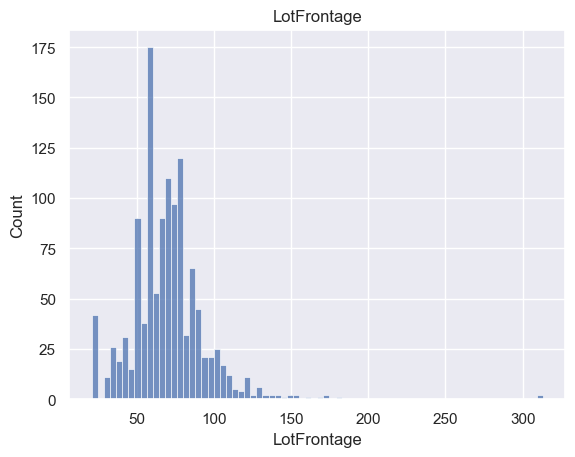

In [46]:
sns.histplot(numerical_have_missing['LotFrontage'])
plt.title('LotFrontage')
plt.show()

In [47]:
# 60~80사이의 random한 value로 결측치 대체 - List comprehension을 활용해 반복문을 한 줄 코드로 작성
old_LotFrontage = list(numerical_have_missing['LotFrontage'].values)
missing_indices = list(numerical_have_missing.loc[numerical_have_missing['LotFrontage'].isnull(), 'LotFrontage'].index)
random_values = [random.randint(60,80) for _ in range(1460 - numerical_have_missing['LotFrontage'].count())]
random_values_idx = 0

for missing_idx in missing_indices:
  old_LotFrontage[missing_idx] = random_values[random_values_idx]
  random_values_idx += 1

numerical_have_missing['LotFrontage'] = pd.Series(old_LotFrontage)
train_data['LotFrontage'] = pd.Series(old_LotFrontage)

In [49]:
# categorial 변수 결측치 확인
# 결측치가 매우 많은 FireplaceQu 변수는 삭제
# 나머지 변수들에 대해서는 SimpleImputer를 활용해 최빈값으로 결측치 대체

print(len(categorical_have_missing.columns.values))
print('-'*30)
print(categorical_have_missing.columns.values)
print('-'*30)
print(categorical_have_missing.count())

12
------------------------------
['MasVnrType' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinType2' 'Electrical' 'FireplaceQu' 'GarageType' 'GarageFinish'
 'GarageQual' 'GarageCond']
------------------------------
MasVnrType      1452
BsmtQual        1423
BsmtCond        1423
BsmtExposure    1422
BsmtFinType1    1423
BsmtFinType2    1422
Electrical      1459
FireplaceQu      770
GarageType      1379
GarageFinish    1379
GarageQual      1379
GarageCond      1379
dtype: int64


In [50]:
train_data = train_data.drop(['FireplaceQu'], axis=1)
categorical_have_missing = categorical_have_missing.drop(['FireplaceQu'], axis=1)

In [51]:
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
for feature in categorical_have_missing:
  categorical_have_missing[feature] = imputer.fit_transform(categorical_have_missing[feature].values.reshape((-1,1)))
  train_data[feature] = imputer.fit_transform(train_data[feature].values.reshape((-1,1)))

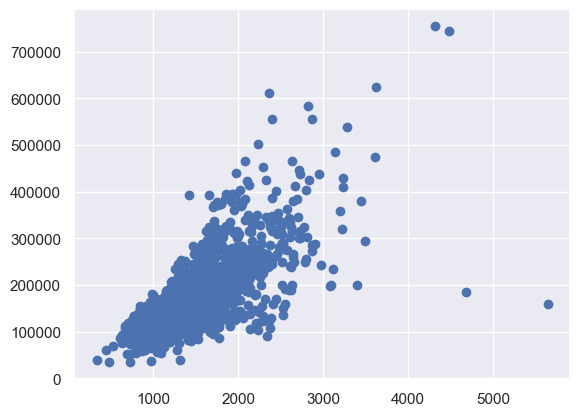

In [52]:
# Outliers(결측치 처리)
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'])
plt.show()

In [53]:
# outlier의 인덱스를 확인한 후 train data에서 제거
train_data[ (train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 200000)].index

Int64Index([523, 1298], dtype='int64')

In [54]:
train_data['Id'] = pd.Series(train_data.index)
train_data = train_data.drop( train_data[ (train_data['Id'] == 1298) | (train_data['Id'] == 523) ].index)
# Delete Id again
train_data = train_data.drop(['Id'], axis=1)

In [55]:
# 더미 변수 생성
train_data = pd.get_dummies(train_data)

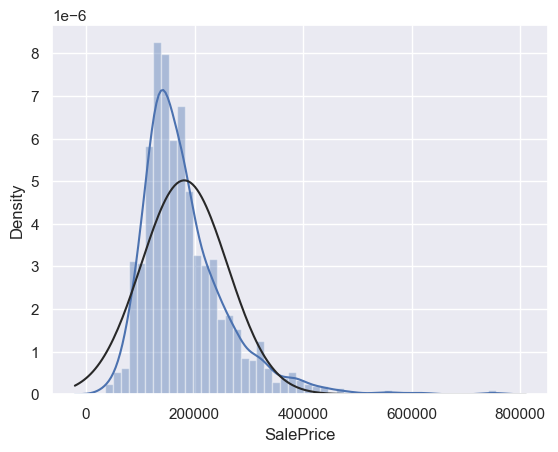

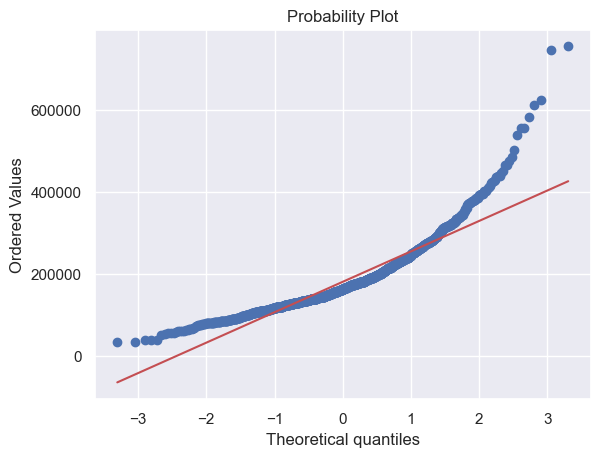

In [56]:
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

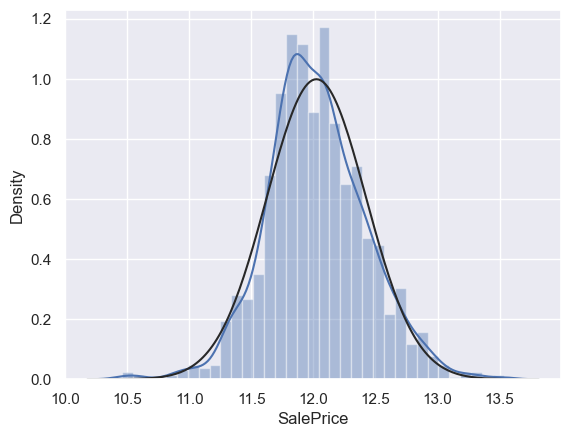

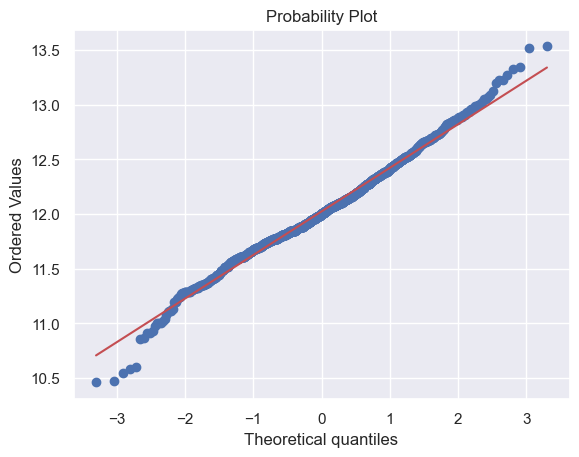

In [57]:
# 그래프를 보면 정규분포를 따르지 않는다. log화 해야 해결함
train_data['SalePrice'] = np.log(train_data['SalePrice'])
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

In [58]:
# Modeling
target = train_data['SalePrice']
train_data = train_data.drop(['SalePrice'], axis=1)

X, y = train_data, target

In [59]:
# LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
pred = lin_reg.predict(X)
print(lin_reg.score(X,y))
np.sqrt(mean_squared_log_error(pred,y))

0.9361246593196328


0.007866343955772539

In [60]:
# RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X, y)
pred = forest_reg.predict(X)
print(forest_reg.score(X, y))
np.sqrt(mean_squared_log_error(pred, y))

0.9819282999190794


0.004193734411412174

In [61]:
# XGBRegressor
xg_reg = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 300, seed = 123)
xg_reg.fit(X, y)
pred = xg_reg.predict(X)
print(xg_reg.score(X, y))
np.sqrt(mean_squared_log_error(pred, y))

0.9999781301779621


0.00014416657538992512